In [2]:
import dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)

data_dir = '/Volumes/X/Kaggle_Data/datasciencebowl2017/stage1/'
# data_dir = '/Users/httbser/Downloads/Kaggle_Data/datasciencebowl2017/data/sample_images/'
patients = os.listdir(data_dir)   # show the file under sample_images
labels_df = pd.read_csv('/Volumes/X/Kaggle_Data/datasciencebowl2017/stage1_labels.csv', index_col=0)
# labels_df = pd.read_csv('/Users/httbser/Downloads/Kaggle_Data/datasciencebowl2017/data/stage1_labels.csv', index_col=0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [3]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))   # 以图像位置属性来对slices排序
    print(len(slices),label)
    print(slices[0])     # 以第一个病人的第一张slice为例，输出dicom文件具有的属性。

150 0
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113654.2.55.236094345075899342562342242717606064280
(0008, 0060) Modality                            CS: 'CT'
(0008, 103e) Series Description                  LO: 'Axial'
(0010, 0010) Patient's Name                      PN: 'fbaa8548e6c3753836579c7987d0034d'
(0010, 0020) Patient ID                          LO: 'fbaa8548e6c3753836579c7987d0034d'
(0010, 0030) Patient's Birth Date                DA: '19000101'
(0018, 0060) KVP                                 DS: ''
(0020, 000d) Study Instance UID                  UI: 2.25.94535280059959484846507363631448779120236926085677029103103
(0020, 000e) Series Instance UID                 UI: 2.25.23939792627805164141579312643552661066025896434800399874563
(0020, 0011) Series Number                       IS: '2'
(0020, 0012) Acquisition Number      

In [15]:
for patient in patients[:3]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices), slices[0].pixel_array.shape)   # 每个病人的slices数量也不一样，即depth不一样，也需要resize。

150 (512, 512)
180 (512, 512)
136 (512, 512)


In [4]:
len(patients)     # 病人总数

1595

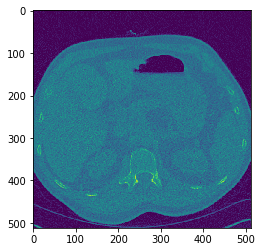

In [5]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    plt.imshow(slices[0].pixel_array)   # 显示第一个病人的第一张slice
    plt.show()

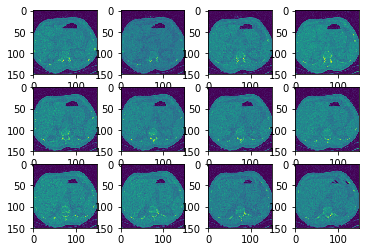

In [7]:
import matplotlib.pyplot as plt
import cv2    # opencv可以resize图片
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    fig = plt.figure()
    for num, each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3, 4, num+1)
        
        # 用opencv来resize每张slice的大小到(IMG_PX_SIZE,IMG_PX_SIZE)
        new_image = cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE))
        y.imshow(new_image)
#         y.imshow(new_image, cmap='gray')   以灰色图像显示
    plt.show()

In [8]:
# All we really need to do is take the image or slices, put them into a list of slices, and chunk that list
# of slices into a fixed number of chunks of slices and then you just average those chunks.
import math
import matplotlib.pyplot as plt
import cv2    # opencv可以resize图片
import numpy as np

IMG_PX_SIZE = 150
HM_SLICES = 20    # 分成的chunk数  把每个病人的slices个数resize到20（20个chunk）

def chunks(l, n):   # chunk a list into a list of lists
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):   # mean of a list
    return sum(l) / len(l)

for patient in patients[:10]:
    try:
        label = labels_df.get_value(patient, 'cancer')
        path = data_dir + patient

        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

        new_slices = []

        # resized slices
        slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE)) for each_slice in slices] 

        # we want 20 chunks，but what about this generator that will just chunk into n-sized chunks
        # math.ceil() 返回数字的上入整数   chunk_sizes：chunk的大小（一个chunk中有多少slices）
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)  # give us the chunk sizes where it produces how many chunks

        for slice_chunk in chunks(slices, chunk_sizes):  
            # slice_chunk，a list of slices we need to average those together
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)  
    except:
        # some patients don't have labels, so we'll just pass on this for now
        pass
    
    print(len(slices), len(new_slices))   # 每个病人多少slices，每个病人的slices分成了的chunk数

150 19
180 20
136 20
265 19
121 18
235 20
235 20
157 20
263 19
156 20


150 20


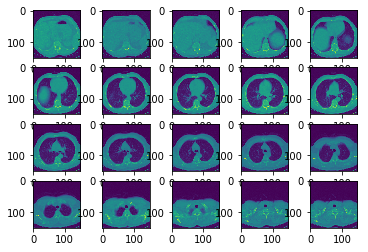

In [10]:
# 让每个病人的slices对应的chunk数都为20，即每个病人都有20个new_slices
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient

    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE)) for each_slice in slices] 
    chunk_sizes = math.ceil(len(slices) / HM_SLICES) 

    for slice_chunk in chunks(slices, chunk_sizes):  
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)  
        
    # 如果new_slices的长度和HM_SLICES不一致 比如18、19、21、22
    if len(new_slices) == HM_SLICES-1:   
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val   
        
    print(len(slices), len(new_slices))  # new_slices的长度
            
    fig = plt.figure()
    for num, each_slice in enumerate(new_slices):
        y = fig.add_subplot(4, 5, num+1)
        y.imshow(each_slice)
    plt.show()


In [13]:
# 预处理数据
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import dicom

IMG_PX_SIZE = 50
HM_SLICES = 20

data_dir = '/Volumes/X/Kaggle_Data/datasciencebowl2017/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('/Volumes/X/Kaggle_Data/datasciencebowl2017/stage1_labels.csv', index_col=0)

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i : i+n]

def mean(l):
    return sum(l) / len(l)

def process_data(patient, labels_df, img_px_size=50, hm_slices=20, visualize=False):
    label = labels_df.get_value(patient, 'cancer')
    path = data_dir + patient

    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    # resize the image
    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE)) for each_slice in slices] 
    chunk_sizes = math.ceil(len(slices) / HM_SLICES) 

    for slice_chunk in chunks(slices, chunk_sizes):  
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)  
        
    # 如果new_slices的长度和HM_SLICES不一致 比如18、19、21、22
    if len(new_slices) == HM_SLICES-1:   
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES]])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val   
        
#     print(len(slices), len(new_slices))  # new_slices的长度
            
    if visualize: 
        fig = plt.figure()
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(4, 5, num+1)
            y.imshow(each_slice)
        plt.show()
    
    if label==1: label = np.array([0, 1])
    elif label==0: label = np.array([1, 0])
        
    return np.array(new_slices), label

much_data = []

for num, patient in enumerate(patients[:1]):
    if num % 100 == 0:
        print(num)   
    try:
        img_data, label = process_data(patient, labels_df, img_px_size=IMG_PX_SIZE, hm_slices=HM_SLICES)
        much_data.append([img_data, label])
    except KeyError as e:
        print('This is unlabeled data!')

# save the array of arrays to a file
np.save('muchdata-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, HM_SLICES), much_data)

0


In [ ]:
# 3D Convnets
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 20

n_classes = 2
batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')

def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output


much_data = np.load('muchdata-50-50-20.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-100]
validation_data = much_data[-100:]


def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 10
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)

# Run this locally:
# train_neural_network(x)